 Dataset available on google drive link :  
 https://drive.google.com/drive/u/0/folders/12stEp_lPCiMu42ulNoCJfdS03bsXF5j2

In [2]:
# data handlig and linear algebra
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns

# data analysis
from sklearn.model_selection  import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

# manipulating data  and model building
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Sequential




In [3]:
DIR_TRAIN_IMAGES="/content/drive/MyDrive/RooftopDtaset/ProjectSolarPanelDetection/training/"
DIR_TRAIN_LABELS="/content/drive/MyDrive/RooftopDtaset/ProjectSolarPanelDetection/labels_training_MLproject.csv"

In [4]:
pd.read_csv(DIR_TRAIN_LABELS).head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


id = names of the images before tif

label has two values:

**0:** No solar panels in the images

**1:**  solar panel in images

In [5]:
# loading data and preprocessing

def load_data(dir_data,dir_labels):
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data=[]
    for i in ids:
      fname = dir_data + i.astype(str) + '.tif'
      image =  mpl.image.imread(fname)
      data.append(image)

    data=np.array(data)
    labels = labels_pd.label.values
    return data,labels

In [6]:
X,y = load_data(DIR_TRAIN_IMAGES,DIR_TRAIN_LABELS)

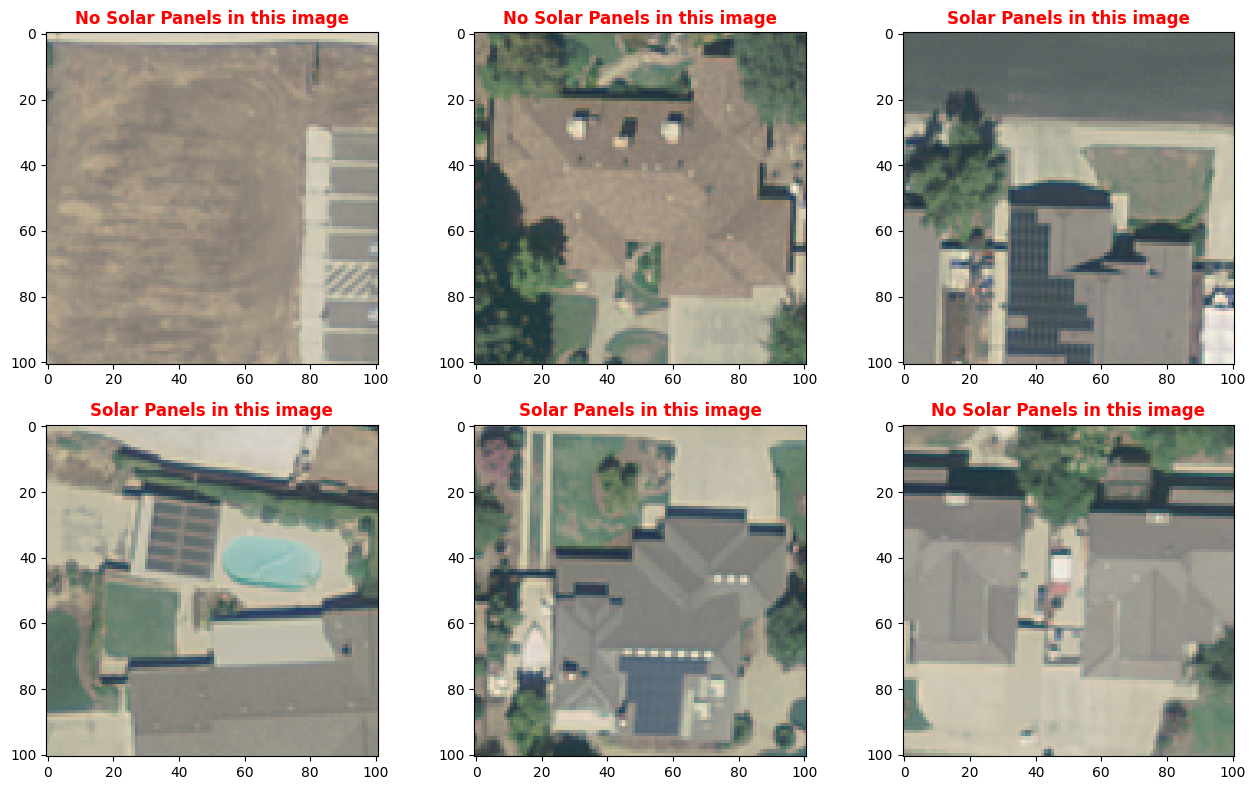

In [7]:
plt.figure(figsize = (13,8))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(X[i])
  if y[i] == 0:
    title = 'No Solar Panels in this image'
  else:
    title = 'Solar Panels in this image'
  plt.title(title, color = 'r', weight = 'bold')
plt.tight_layout()
plt.show()

In [8]:
print('X Shape is  ',X.shape)

X Shape is   (1500, 101, 101, 3)


In [9]:
print('disttribution of y is as ' ,np.bincount(y))

disttribution of y is as  [995 505]


In [10]:
# scaling the data
X = X/255.0

BUILDING CNN MODEL

In [12]:
def build_model():
  IMAGE_HEIGHT=101
  IMAGE_WIDTH=101
  IMAGE_CHANNELS=3

  model = Sequential()
# layer1
  model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  # layer2
  model.add(Conv2D(filters=64,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  # layer3
  model.add(Conv2D(filters=128,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=2))

  # layer4
  model.add(Conv2D(filters=64,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())

  #  layer5
  model.add(Conv2D(filters=128,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=2))
  # layer6
  model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())

  # layer7

  model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(BatchNormalization())

  model.add(GlobalMaxPooling2D())

  #outlayer
  model.add(Dense(1,activation='sigmoid'))

  #compile model
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

  return model


checking performance of cnn model

In [17]:

def cv_performance_assessment(X,y,num_folds,clf,random_seed=1):
   prediction_scores = np.empty(y.shape[0],dtype='object')
   kf = StratifiedKFold(n_splits = num_folds,shuffle=True,random_state=random_seed)

   for train_index,val_index in kf.split(X,y):

      X_train,X_val = X[train_index],X[val_index]
      y_train = y[train_index]

      class_weight ={0:505/1500 , 1:995/1500}

      training = clf.fit(x=X_train,y=y_train,class_weight =class_weight,
                       batch_size=32,epochs=10,shuffle=True,verbose=1)

      y_val_pred_probs =clf.predict(X_val).reshape((-1, ))


      prediction_scores[val_index] = y_val_pred_probs

   return prediction_scores



In [18]:
num_folds = 3

random_seed = 1

cnn= build_model()

cnn.summary()

cnn_y_hat_prob = cv_performance_assessment(X,y,num_folds,cnn,random_seed=random_seed)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 99, 99, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 99, 99, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 97, 97, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 95, 95, 128)       73856     
                                                                 
 batch_normalization_9 (Bat  (None, 95, 95, 128)      

true positives,false negatives,false positives, and true negatives


In [21]:
df = pd.read_csv(DIR_TRAIN_LABELS)                                              # Create a data frame of labels
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]    # Add a column to it for predicted class

# Get the values for FN, FP, TP, TN
fn = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 0)]['id'])      # False Negative
fp = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 1)]['id'])      # False Positive
tp = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 1)]['id'])      # True Positive
tn = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 0)]['id'])


In [22]:
# Visuals of TP, TN, FP, and FN
def show_images(image_ids, num_images, title, color):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4                                          # Adjusting figure size
    plt.figure()                                                                # Generating figure
    n = 1                                                                       # index where plot should apear in subplot
    for i in image_ids[0:num_images]:                                           # Run a loop for total number of images to display
        plt.subplot(1, num_images, n)                                           # Generate a subplot
        plt.imshow(X[i, :, :, :])                                               # Display the image
        plt.title('Image id: ' + str(i))                                        # Add title
        plt.axis('off')                                                         # Turn off the axis
        n+=1                                                                    # Incrememting index by 1
    plt.suptitle('\n'+title, fontsize=15, color = color, weight = 'bold')       # Adding main title to subplot
    plt.show()

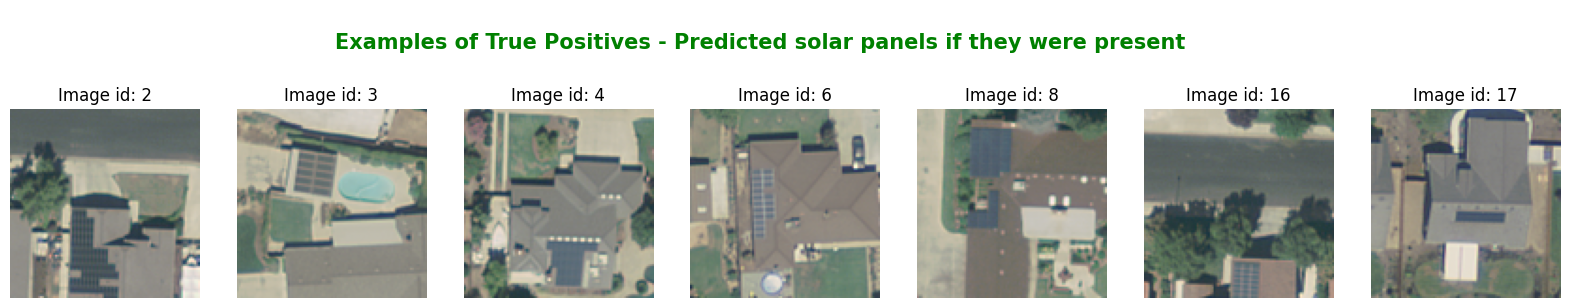

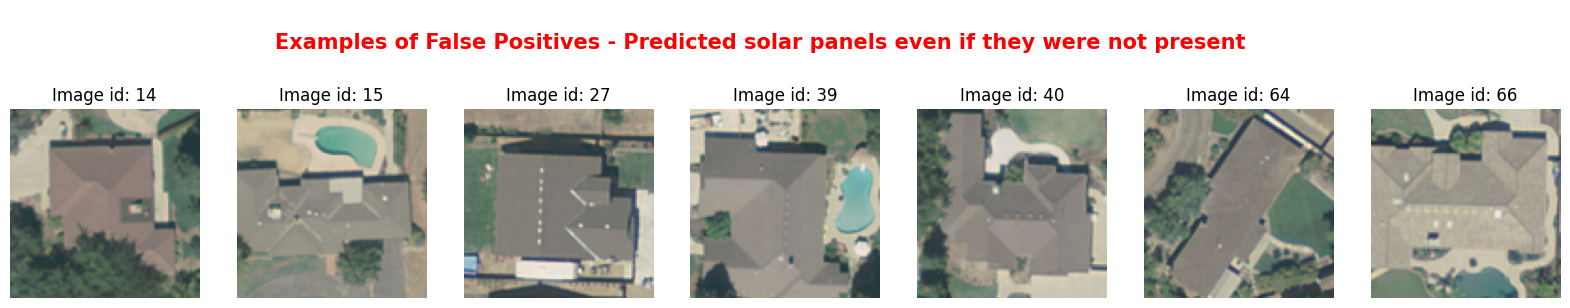

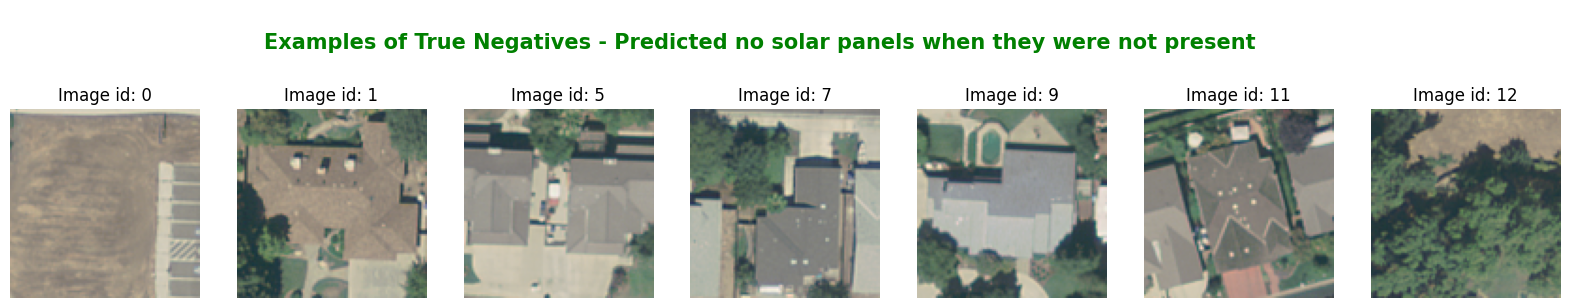

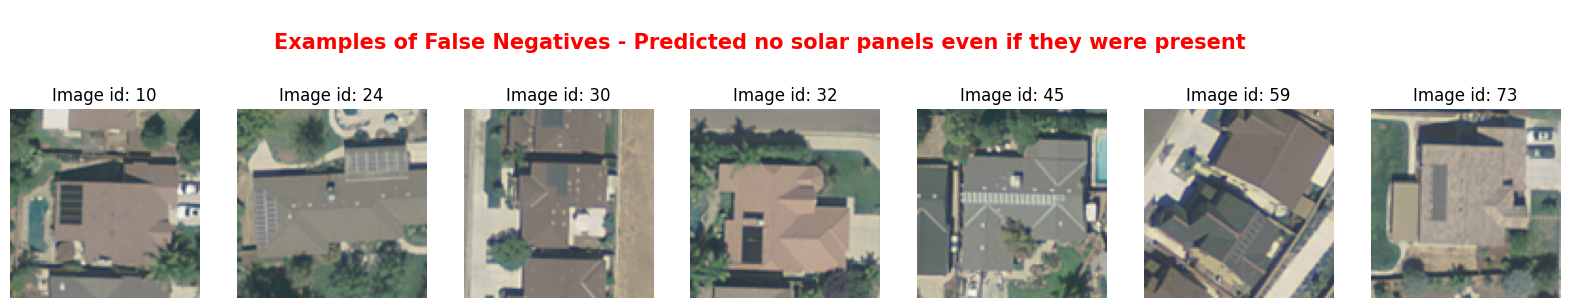

In [23]:
num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

In [24]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

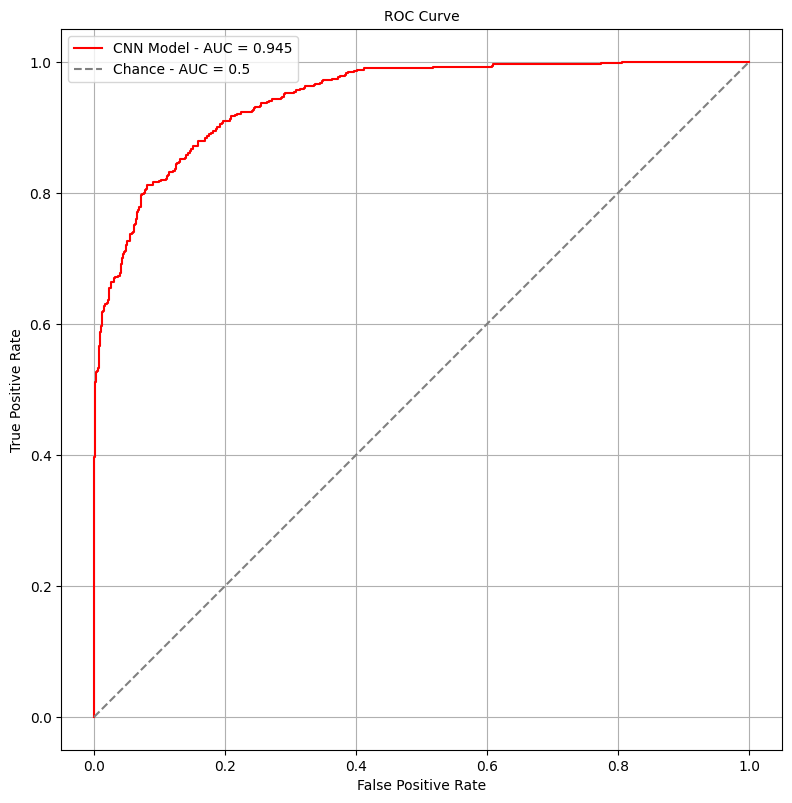

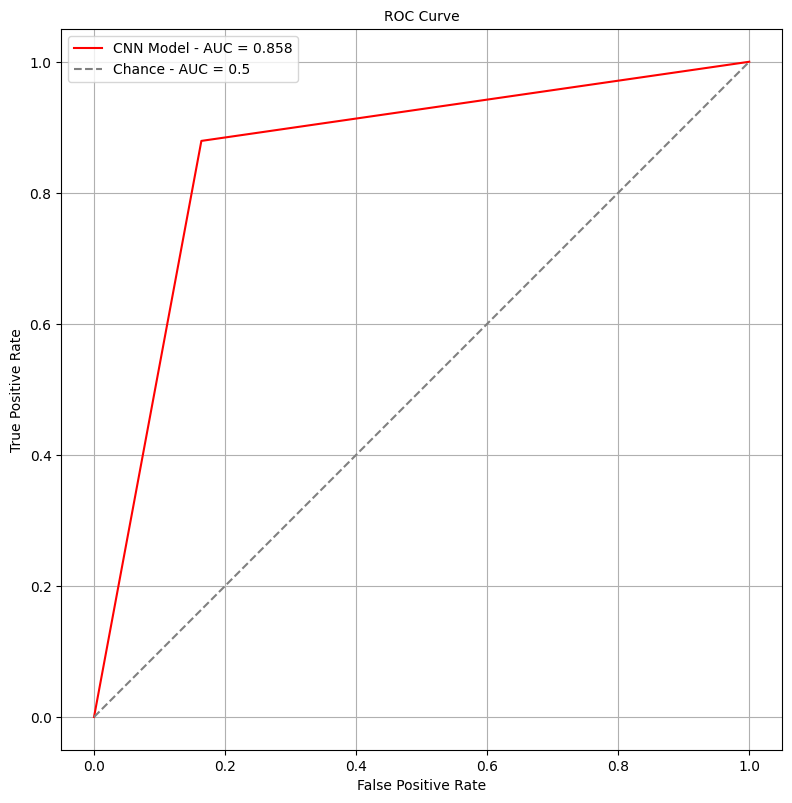

In [25]:
# plot ROC
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

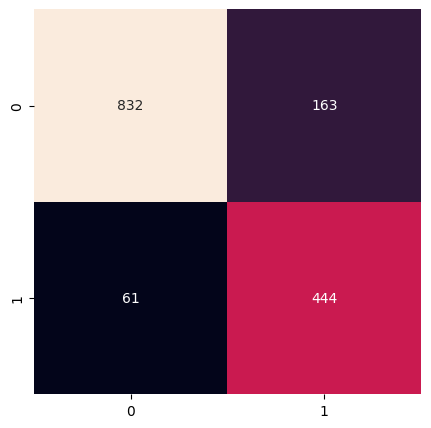

In [26]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()
